In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")


In [2]:
import collections

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [4]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from torchinfo import summary

In [6]:
import os

In [7]:
import glob

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!ls drive/'My Drive'

 articles.csv	    hotdog_nothotdog	    test.csv
'Colab Notebooks'   images		    train.csv
 customers.csv	    sample_submission.csv   transactions_train.csv
 data_utils.py	    submission.csv


In [10]:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())


In [11]:
image_paths = glob.glob("drive/My Drive/hotdog_nothotdog/train/hotdog/*.jpg")
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
#train = pd.read_csv('drive/My Drive/train.csv')
#train_images = ['drive/My Drive/images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
#test = pd.read_csv('drive/My Drive/test.csv')

Total Observations:	 1075


In [12]:
#data_transforms = {
#    'train': transforms.Compose([
#        transforms.Resize(256),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#    ]),
#    'test': transforms.Compose([
#        transforms.Resize(256),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#    ]),
#}
#data_transforms = {
#    'train': transforms.Compose([
#        transforms.RandomResizedCrop(224),
#        transforms.RandomHorizontalFlip(),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#    ]),
#    'test': transforms.Compose([
#        transforms.Resize(256),
#        transforms.CenterCrop(224),
#        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#    ]),
#}

#data_transforms={
#'train': transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]),
#'test': transforms.Compose([transforms.Resize(224),
#                                      transforms.CenterCrop(224), 
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]),
#}


#transforms = transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32), transforms.ToTensor()]) 


data_transforms={
'train': transforms.Compose([transforms.Resize(32),transforms.CenterCrop(32),transforms.ToTensor()]),
                                       
'test': transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(32), 
                                      transforms.ToTensor()])
}

In [13]:
data_dir = 'drive/My Drive/hotdog_nothotdog'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class_names

['hotdog', 'nothotdog']

In [15]:
def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [17]:
#train_loader = DataLoader(dataloaders['train'], batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
#test_loader = DataLoader(dataloaders['test'], batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

train_loader = dataloaders['train']
test_loader = dataloaders['test']

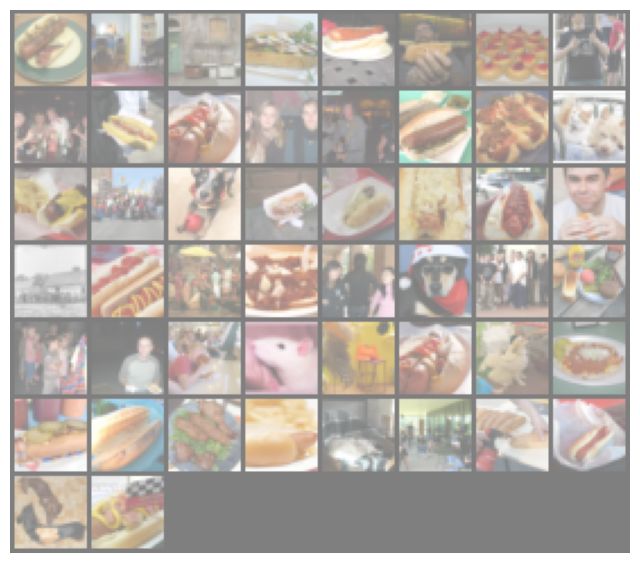

In [19]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

In [22]:
print("Training data")
print("Number of points:", len(train_loader))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(dataloaders['train'].targets))} (unique labels: {set(dataloaders['train'].targets)})")

print("\nTest data")
print("Number of points:", len(test_loader))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

#n_classes = len(set(dataloaders['test'].targets))

Training data
Number of points: 41
Batch dimension (B x C x H x W): torch.Size([50, 3, 32, 32])

Test data
Number of points: 38
Batch dimension (B x C x H x W): torch.Size([50, 3, 32, 32])


In [23]:
#import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512 , 32)
        self.fc2 = nn.Linear(32, 2)
        self.sf=nn.Softmax(dim=1)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        #print('hej',out.size())
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        #print('hej1',out.size())
 
        #out = out.view(-1, 8 * 8)
        out = torch.flatten(out, 1)
        #print('hej1',out.size())
        out = torch.tanh(self.fc1(out))
        #print('hej2',out.size())
        out = self.fc2(out)
        #print(out)
        return out

In [24]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #32 chang to 224
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)) #10
        
    def forward(self, xb):
        return self.network(xb)

In [25]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [26]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 245MB/s]


In [28]:

#model_ft.fc = nn.Linear(num_ftrs, 2)
#model = model_ft.to(device)

#model = NetResDeep(n_chans1=32, n_blocks=2).to(device=device)
model=Net().to(device)
#model=Net1().to(device)

In [29]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (sf): Softmax(dim=1)
)


In [30]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            448
├─Conv2d: 1-2                            1,160
├─Linear: 1-3                            16,416
├─Linear: 1-4                            66
├─Softmax: 1-5                           --
Total params: 18,090
Trainable params: 18,090
Non-trainable params: 0

In [31]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
#loss_fn = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Your code here!
#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.02)

In [32]:
out = model(torch.randn(2, 3, 32, 32,device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 2])
Output logits:
[[ 0.2309933  -0.15424618]
 [ 0.18316299 -0.10019989]]
Output probabilities:
[[0.5951362  0.40486383]
 [0.5703705  0.42962953]]


In [33]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [34]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-06-05 13:14:40.284728 Epoch 1, Training loss 0.6921541298308024
2023-06-05 13:16:38.741955 Epoch 10, Training loss 0.6812913781259118
2023-06-05 13:18:48.510309 Epoch 20, Training loss 0.6234399065738772
2023-06-05 13:20:58.961237 Epoch 30, Training loss 0.575466052061174
2023-06-05 13:23:08.423027 Epoch 40, Training loss 0.544266535014641
2023-06-05 13:25:19.106603 Epoch 50, Training loss 0.532079155852155
2023-06-05 13:27:28.343947 Epoch 60, Training loss 0.5241611636266476
2023-06-05 13:29:38.888465 Epoch 70, Training loss 0.5182029924741606
2023-06-05 13:31:48.602583 Epoch 80, Training loss 0.5101180650838991
2023-06-05 13:33:59.127416 Epoch 90, Training loss 0.5027867780952919
2023-06-05 13:36:09.097301 Epoch 100, Training loss 0.491471743438302


In [35]:
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, test_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("test", test_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [36]:
all_acc_dict["baseline"] = validate(model, train_loader, test_loader)

Accuracy train: 0.77
Accuracy test: 0.61
